# Project 3. Limited time training

 In project 3, you're going to improve your network under the limitation of time, specifically 10 minutes. You can borrow any structure that you consider viable, but pretrained models are **NOT allowed**.

**Hint**: Most of the popular networks can't converge in 10 minutes, so if you decide to borrow any, you'd have to trim the network a little to fit into the time frame.

## 1. Preparation

This project is time limited, we need to make sure that your hardwares are exactly the same, try the following code, if you see 'GPU correct, proceed.', you can continue the project, otherwise, click the dropdown at the upper right corner besides the status bar (RAM, Disk), and go to 'Manage sessions', and terminate the current session, then reconnect, and try the code again, repeat until you see the right message.

In [ ]:
!if [ $(nvidia-smi | grep Tesla | tr -s " " | cut -d' ' -f4) == 'T4' ]; then echo "GPU correct, proceed."; else echo "GPU incorrect, please terminate this session and reconnect again."; fi

!nvidia-smi

GPU correct, proceed.
Sun May 21 01:20:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    28W /  70W |   1773MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                  

## 2. Before training

For dataset, we continue to use CIFAR10, in this part, you can configure all of your settings, including data augmentation, model structure, optimizer etc., but don't put any major calculation part in.

### 2.1 Dataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR



transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

cifar10_train = torchvision.datasets.CIFAR10("CIFAR10", train=True, transform=transform_train,
                                             target_transform=None, download=True)

cifar10_test = torchvision.datasets.CIFAR10("CIFAR10", train=False, transform=transform_test,
                                            target_transform=None, download=True)

dataloader = DataLoader(cifar10_train, batch_size=512, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available")
else:
    device = torch.device("cpu")
    print("CUDA is not available")

x = torch.randn(3, 3).to(device)
print(x)
print(torch.version.cuda)

CUDA is available
tensor([[ 0.4408,  2.1486,  0.5832],
        [-0.1288,  0.8949, -0.9499],
        [-1.5533,  1.2162, -0.1946]], device='cuda:0')
11.8


### 2.2 Model

**Hint**: Even though pretrained models are not allowed in your final version, you can use pretrained models to determine how well the structure CAN perform and use this as part of your analysis as to determining network structure.

**Model definition**

In [ ]:
import torchvision.models
# ！pip install torchsummary
from torchsummary import summary

# Define a PyTorch neural network class

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        
        # Define the convolutional feature extraction layers
        self.features_1 = nn.Sequential( 
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),   # output: 32 x 32 x 64
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # output: 32 x 32 x 64
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # output: 16 x 16 x 64
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # output: 16 x 16 x 128
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
        )
        self.features_2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # output: 16*16*128
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
        )
        self.features_3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # output: 16*16*128
            nn.BatchNorm2d(128),
        )
        self.features_4 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # output: 8 x 8 x 128
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),# output: 8 x 8 x 256
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),# output: 4 x 4 x 512
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.AdaptiveAvgPool2d((1, 1)),                            # output: 1 x 1 x 512
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x_1 = self.features_1(x)
        x_2 = self.features_2(x_1)
        x_3 = self.features_3(x_2) + x_1
        x = self.features_4(x_3)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x





# class MyNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.backbone = torchvision.models.vgg19(num_classes=10)
    
#     def forward(self, data):
#         return self.backbone(data)

# class MyNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.backbone = torchvision.models.resnet50(num_classes=10)
    
#     def forward(self, data):
#         return self.backbone(data)

# class MyNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.backbone = torchvision.models.resnet18(num_classes=10)
    
#     def forward(self, data):
#         return self.backbone(data)


# def conv_block(in_channels, out_channels, pool=False):
#     layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#               nn.BatchNorm2d(out_channels),
#               nn.ReLU(inplace=True)]
#     if pool: layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
#     return nn.Sequential(*layers)


# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(self, in_channels, out_channels, stride=1):
#         super(BasicBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(out_channels)
#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_channels != self.expansion * out_channels:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion * out_channels)
#             )

#     def forward(self, x):
#         identity = x
#         out = self.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += self.shortcut(identity)
#         out = self.relu(out)
#         return out


# class ResNet(nn.Module):
#     def __init__(self, block, num_blocks, num_classes=10):
#         super(ResNet, self).__init__()
#         self.in_channels = 64
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
#         self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
#         self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)
#         self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512 * block.expansion, num_classes)

#     def make_layer(self, block, out_channels, num_blocks, stride):
#         layers = []
#         layers.append(block(self.in_channels, out_channels, stride))
#         self.in_channels = out_channels * block.expansion
#         for _ in range(1, num_blocks):
#             layers.append(block(self.in_channels, out_channels))
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = self.relu(self.bn1(self.conv1(x)))
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.avg_pool(out)
#         out = torch.flatten(out, 1)
#         out = self.fc(out)
#         return out


# def MyNet():
#     return ResNet(BasicBlock, [2, 2, 2, 2])

net = MyNet().cuda()
summary(net, input_size=(3, 32, 32))


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4           [-1, 64, 32, 32]          36,928
              ReLU-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
              ReLU-9          [-1, 128, 16, 16]               0
      BatchNorm2d-10          [-1, 128, 16, 16]             256
           Conv2d-11          [-1

In [ ]:
# !pip install torchviz graphviz
# import torch
# import torch.nn as nn
# from torchviz import make_dot
# model = MyNet()
# dummy_input = torch.zeros((1, 3, 32, 32))
# output = model(dummy_input)
# graph = make_dot(output, params=dict(model.named_parameters()))
# graph.render("network_graph", format="png")


**Analysis tools**

In [ ]:
def testset_precision(net, testset):
    net.eval()
    dl = DataLoader(testset, batch_size=512)
    total_count = 0
    total_correct = 0
    for data in dl:
        inputs = data[0].cuda()
        targets = data[1].cuda()
        outputs = net(inputs)
        predicted_labels = outputs.argmax(dim=1)
        comparison = predicted_labels == targets
        total_count += predicted_labels.size(0)
        total_correct += comparison.sum()
    net.train()
        
    return int(total_correct) / int(total_count)

print(f'Inital precision: {testset_precision(net, cifar10_test)}')

from IPython import display
import matplotlib.pyplot as plt
import time

class DrawingBoard:
    def __init__(self, names, time_slot=60):
        self.start_time = time.time()
        self.time_slot = time_slot
        self.annotations = []
        self.data = {}
        for name in names:
            self.data[name] = []
    
    def update(self, data_dict):
        for key in data_dict:
            self.data[key].append(data_dict[key])
        current_time = time.time() - self.start_time
        idx = len(self.data[key]) -1
        if len(self.annotations) == 0:
            if current_time > self.time_slot:
                self.annotations.append((idx, current_time))
        elif current_time - (self.annotations[-1][1]//self.time_slot)*self.time_slot > self.time_slot:
            self.annotations.append((idx, current_time))
    
    def draw(self):
        all_keys = list(self.data.keys())
        fig, ax = plt.subplots(nrows=1, ncols=len(all_keys))
        fig.set_figwidth(20)
        for idx in range(len(all_keys)):
            ax[idx].plot(self.data[all_keys[idx]])
            ax[idx].set_title(all_keys[idx])
            for an in self.annotations:
                ax[idx].annotate(f'{int(an[1])}s', xy=(an[0], self.data[all_keys[idx]][an[0]]),
                    xytext=(0, -40), textcoords="offset points",
                    va="center", ha="left",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
        display.clear_output(wait=True)
        plt.show()

Inital precision: 0.1


In [ ]:
# modify as you need
Epoch = 20
#12
best_precision = 0
current_precision = 0
loss = 0
# 60000/2048 = 30
accumulate_batches = 40
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(net.parameters(), lr=0.001)
# dataloader = DataLoader(cifar10_train, batch_size=512, shuffle=True)
# Define scheduler
scheduler = StepLR(optimizer, step_size=4, gamma=0.5)

## 3. Start Training

This is the training part, take advantage of everything you know. In addition to the tips last time, you can also consider data augmentation, short cut structure in ResNet etc.

Basically at this point, nothing is limited except time and pretrained models.

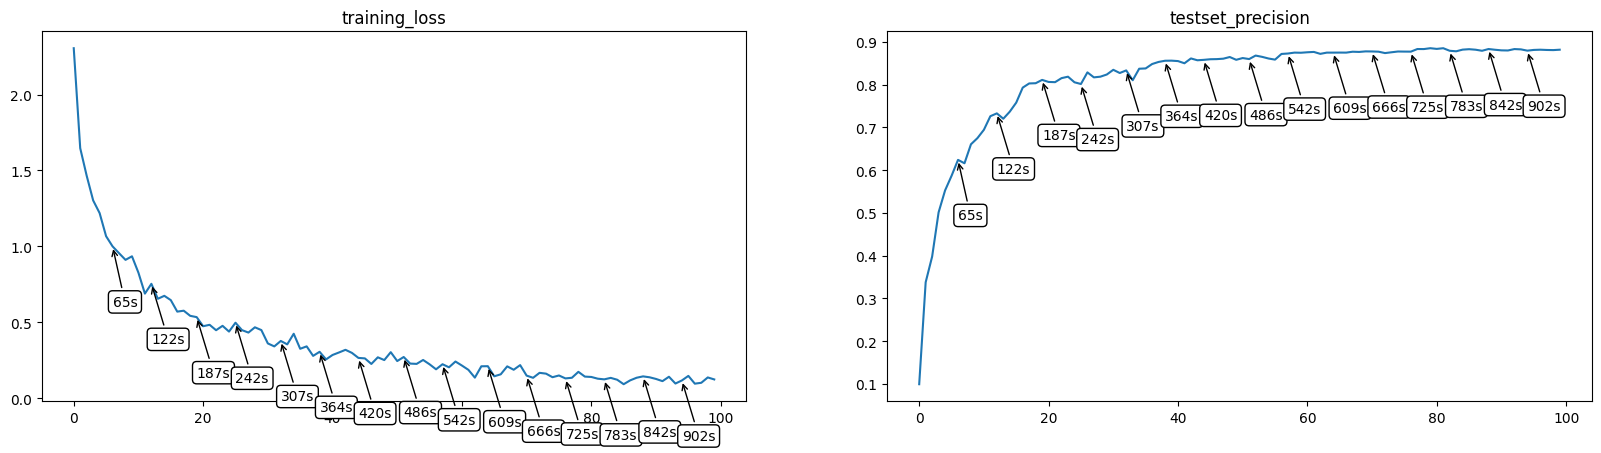

finished
Best precision: 0.8852  | loss: tensor(0.1197, device='cuda:0', grad_fn=<NllLossBackward0>)  | Best_epoch: 15


In [ ]:
# modify as you need
import time
import signal
import copy
from torch.cuda.amp import autocast, GradScaler

class TimeLimitation:
    def __init__(self, limit):
        self.limit = limit

    def __enter__(self):
        def handler(signum, frame):
            raise NotImplementedError('Time\'s up')
        signal.signal(signal.SIGALRM, handler)
        signal.alarm(self.limit)

    def __exit__(self, exc_type, exc_val, exc_tb):
        signal.alarm(0)


with TimeLimitation(600):  # don't forget the indentation
    # Create an empty gradient accumulator
    accumulator = None
    print('start training')
    db = DrawingBoard(['training_loss', 'testset_precision'], time_slot=60)

    # Create GradScaler object for automatic gradient scaling
    scaler = GradScaler()

    for e in range(Epoch):
        # Update new lr rate before every 4 epochs
        scheduler.step()
        for iter, data in enumerate(dataloader):
            # batch_data
            inputs = data[0].cuda()
            # batch_labels
            targets = data[1].cuda()

            # Enable automatic mixed precision context
            with autocast():
                outputs = net(inputs)
                loss = criterion(outputs, targets)

            optimizer.zero_grad()

            # Automatic gradient scaling, scales the loss value according to the current precision
            scaler.scale(loss).backward()

            # Accumulate gradients
            if (iter + 1) % accumulate_batches == 0:
                if accumulator is None:
                    accumulator = copy.deepcopy(net.state_dict())
                else:
                    accumulator = {
                        param_name: accumulator[param_name] + net.state_dict()[param_name]
                        for param_name in accumulator
                    }

            # Unscale the gradients and perform optimizer step
            scaler.step(optimizer)

            # Update GradScaler for the next iteration
            scaler.update()

            net.zero_grad()
            accumulator = None

            # This 'iter' represents the number of batches that have been trained.
            # In each epoch, the model will iterate through the dataset and perform forward propagation, backward propagation, and parameter updates on each batch.
            # After each batch, the 'iter' is incremented by 1, indicating the completion of training for one batch.
            if iter % 20 == 0:
                current_precision = testset_precision(net, cifar10_test)
                loss = loss.item()
                db.update({'training_loss': loss, 'testset_precision': current_precision})
                db.draw()
                # save the model if it is better
                if current_precision > best_precision:
                    best_precision = current_precision
                    epoch = e
                    print("Best precision:", best_precision, " | loss:", loss, " | Best_epoch:", epoch)
print('finished')
print("Best precision:", best_precision, " | loss:", loss, " | Best_epoch:", epoch)



In [ ]:
print('finished')
print("Best precision:", best_precision, " | loss:", loss, " | Best_epoch:", epoch)

finished
Best precision: 0.8852  | loss: tensor(0.1197, device='cuda:0', grad_fn=<NllLossBackward0>)  | Best_epoch: 15


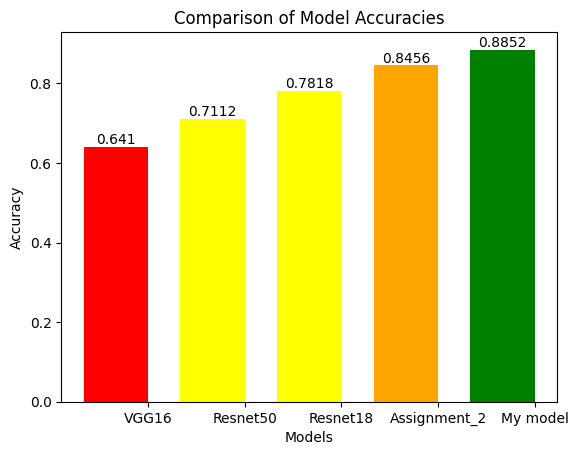

In [ ]:
import matplotlib.pyplot as plt


model_names = ['VGG16', 'Resnet50','Resnet18', 'Assignment_2', 'My model']


accuracies = [0.641, 0.7112, 0.7818, 0.8456, 0.8852]


colors = ['red', 'yellow', 'yellow', 'orange', 'green']


bar_width = 0.1
spacing = 0.05


x = [i * (bar_width + spacing) for i in range(len(model_names))]


plt.bar(x, accuracies, color=colors, width=bar_width)


for i, v in enumerate(accuracies):
    plt.text(x[i], v, str(v), ha='center', va='bottom')


plt.title('Comparison of Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')


plt.xticks([i + bar_width/2 for i in x], model_names)


plt.show()

# Marking Scheme

*   Code implementation: 30%


> * Successfully run through the whole project: 10%
> * Code implementation quality: 20% (including performance)

*   PDF report: 50%

> * Overview, introduction to the network structure etc.: 10%
> * In-depth analysis and improvements: 40%

*   Presentation: 20%

> * Overall demonstration: 10%
> * Unfolding analysis: 10%